# Import Necessary Modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

## Takegrayscale image of size 512x512, add some salt & pepper noise and pererform the following operations

In [2]:
def add_salt_pepper_noise(image, salt_prob=0.02, pepper_prob=0.02):
  noise_image = image.copy()
  total_pixels = image.size
  num_salt = int(total_pixels * salt_prob)
  salt_coords = [np.random.randint(0, i, num_salt) for i in image.shape]
  noise_image[salt_coords[0], salt_coords[1]] = 255
  num_pepper = int(total_pixels * pepper_prob)
  pepper_coords = [np.random.randint(0, i, num_pepper) for i in image.shape]
  noise_image[pepper_coords[0], pepper_coords[1]] = 0

  return noise_image

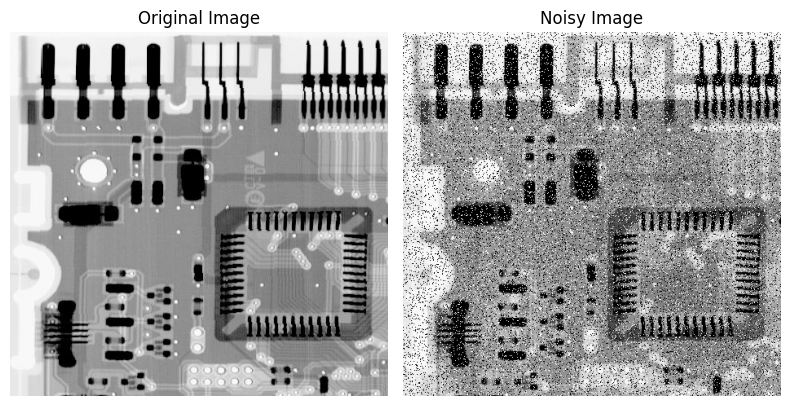

In [19]:
img = cv2.imread('pcb.tif', cv2.IMREAD_GRAYSCALE)

noise_image = add_salt_pepper_noise(img, salt_prob=0.1, pepper_prob=0.1)

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(noise_image, cmap='gray')
plt.title('Noisy Image')
plt.axis('off')

plt.tight_layout()
plt.show()

## (a) Apply average and median spatial filters with 5x5 mask and observe their performance for noise suppression in term of PSNR

## $PSNR = 10 * log_{10}\frac{MAX^2}{MSE}$
## where $MAX = 255$ for 8-bit image
## $MSE = \frac{1}{M \times N}\sum_{x=1}^{M} \sum_{y=1}^{N} (f(x, y)- \hat{f}(x, y))^2$

Average PSNR: 19.748049089947624
Median PSNR: 24.978332621783473


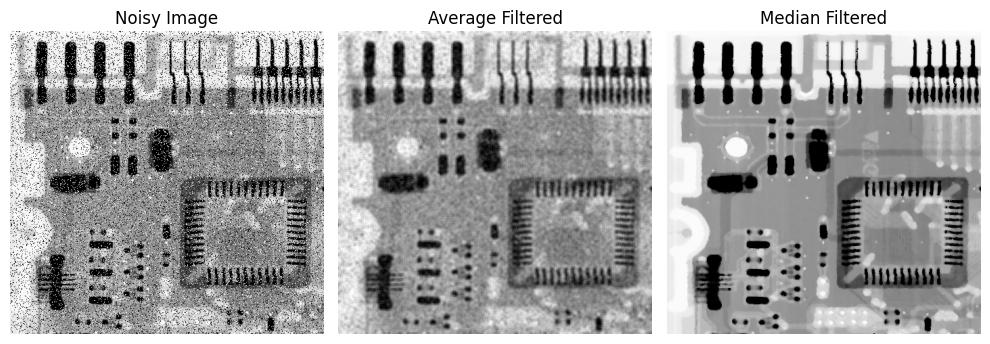

In [5]:
avg_img = cv2.blur(noise_image, (5, 5))
median_img = cv2.medianBlur(noise_image, 5)

psnr = cv2.PSNR(img, avg_img)
print(f'Average PSNR: {psnr}')

psnr = cv2.PSNR(img, median_img)
print(f'Median PSNR: {psnr}')

plt.figure(figsize=(10, 6))

plt.subplot(1, 3, 1)
plt.imshow(noise_image, cmap='gray')
plt.title('Noisy Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(avg_img, cmap='gray')
plt.title('Average Filtered')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(median_img, cmap='gray')
plt.title('Median Filtered')
plt.axis('off')

plt.tight_layout()
plt.show()

## (b) Use different size of mask (3x3, 5x5, 7x7) with average filter for noise suppression and observe their performance in term of PSNR

3x3 PSNR: 19.449272989517418
5x5 PSNR: 19.748049089947624
7x7 PSNR: 18.790325032553095


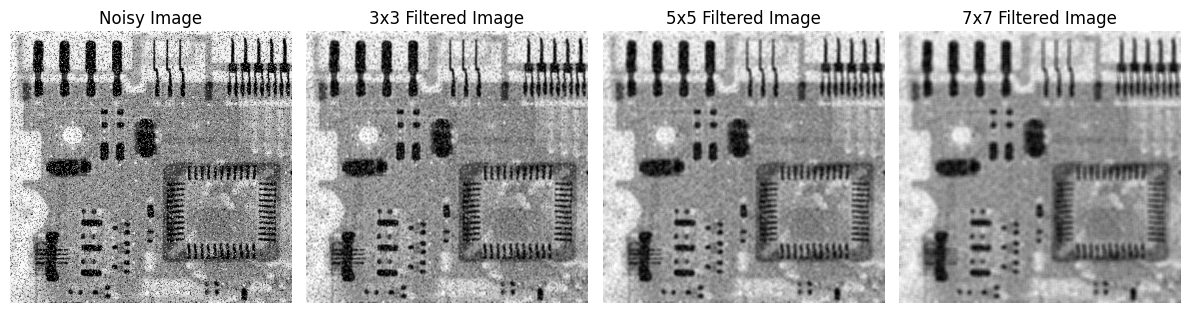

In [6]:
img_3x3 = cv2.blur(noise_image, (3, 3))
img_5x5 = cv2.blur(noise_image, (5, 5))
img_7x7 = cv2.blur(noise_image, (7, 7))

psnr_3x3 = cv2.PSNR(img, img_3x3)
print(f'3x3 PSNR: {psnr_3x3}')
psnr_5x5 = cv2.PSNR(img, img_5x5)
print(f'5x5 PSNR: {psnr_5x5}')
psnr_7x7 = cv2.PSNR(img, img_7x7)
print(f'7x7 PSNR: {psnr_7x7}')

plt.figure(figsize=(12, 8))

plt.subplot(1, 4, 1)
plt.imshow(noise_image, cmap='gray')
plt.title('Noisy Image')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(img_3x3, cmap='gray')
plt.title('3x3 Filtered Image')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(img_5x5, cmap='gray')
plt.title('5x5 Filtered Image')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(img_7x7, cmap='gray')
plt.title('7x7 Filtered Image')
plt.axis('off')

plt.tight_layout()
plt.show()

## Harmonic Mean Filter Function

In [7]:
# Works well for salt noise, but fails for pepper noise
def harmonic_mean_filter(image, mask_size):
  filtered_image = image.copy()
  m, n = image.shape
  k = mask_size // 2

  # Traverse each pixel, excluding the borders where the kernel does not fit
  for i in range(k, m - k):
    for j in range(k, n - k):
      # Calculate the harmonic mean of the neighborhood
      neighborhood = image[i - k : i + k + 1, j - k : j + k + 1]

      # Compute the harmonic mean
      harmonic_mean = np.sum(1.0 / (neighborhood + 1e-5)) # Avoid division by zero
      harmonic_mean = (mask_size * mask_size) / harmonic_mean

      # Ensure the pixel value is in the valid range [0, 255]
      filtered_image[i, j] = np.clip(harmonic_mean, 0, 255)

  return filtered_image.astype(np.uint8)

## Geometric Mean Filter Function

In [21]:
# Works well for pepper noise, but fails for salt noise
def geometric_mean_filter(image, mask_size):
  filtered_image = image.copy().astype(np.float64)
  m, n = image.shape
  k = mask_size // 2

  # Traverse each pixel, excluding the borders where the kernel does not fit
  for i in range(k, m - k):
    for j in range(k, n - k):
      # Calculate the geometric mean of the neighborhood
      neighborhood = image[i - k : i + k + 1, j - k : j + k + 1].astype(np.float64)

      # Mask out zero values
      non_zero_values = neighborhood[neighborhood > 0]

      # If there are non-zero values, compute geometric mean
      if non_zero_values.size > 0:
          product = np.prod(non_zero_values)
          geometric_mean = np.power(product, 1 / non_zero_values.size)
      else:
          geometric_mean = 0  # or keep the original pixel value if you prefer

      # Ensure the pixel value is in the valid range [0, 255]
      filtered_image[i, j] = np.clip(geometric_mean, 0, 255)

  return filtered_image.astype(np.uint8)

## (c) Apply harmonic and geometric mean filter on the noisy image and compare their performance with PSNR

Harmonic PSNR: 6.0464000483510825
Geometric PSNR: 17.935163662247223


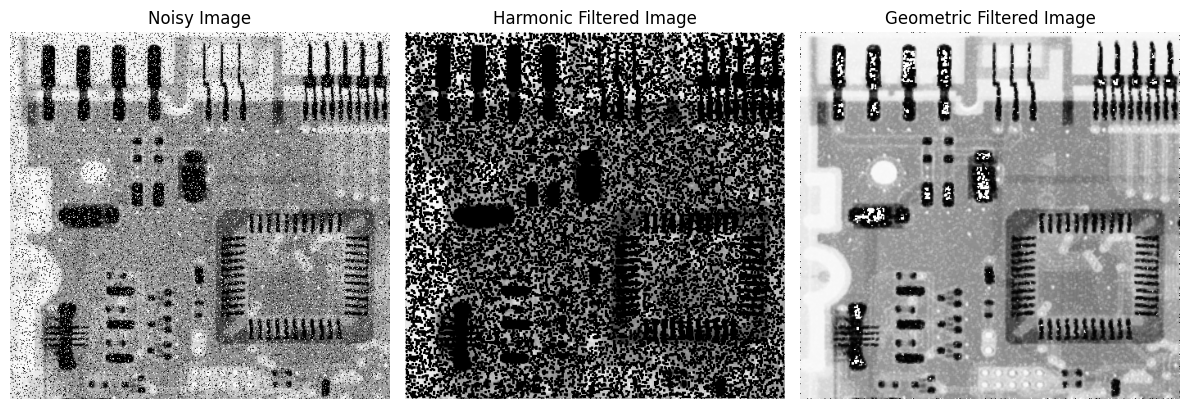

In [22]:
harmonic_filtered = harmonic_mean_filter(noise_image, 3)
geometric_filtered = geometric_mean_filter(noise_image, 3)

psnr_harmonic = cv2.PSNR(img, harmonic_filtered)
print(f'Harmonic PSNR: {psnr_harmonic}')
psnr_geometric = cv2.PSNR(img, geometric_filtered)
print(f'Geometric PSNR: {psnr_geometric}')

plt.figure(figsize=(12, 8))

plt.subplot(1, 3, 1)
plt.imshow(noise_image, cmap='gray')
plt.title('Noisy Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(harmonic_filtered, cmap='gray')
plt.title('Harmonic Filtered Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(geometric_filtered, cmap='gray')
plt.title('Geometric Filtered Image')
plt.axis('off')

plt.tight_layout()
plt.show()